In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
import os
from collections import Counter
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import json

def seed_assign(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)


In [2]:
data_path = '/data2/spike_sorting/neuropixels_choi'
index = 0

In [3]:
# 근데 prob파일에 129번째 채널이 없네?


In [4]:

with open(f'/data2/spike_sorting/neuropixels_choi/set{index+1}/set{index+1}_channel_info.json', 'r') as f:
    channel_info =  json.load(f)


In [5]:
geometry = channel_info['geometry']
graph = channel_info['graph']

In [6]:
# 알 수 있는 것 : 0부터 128이네. 즉 0부터 부여.
geometry 

{'7': [20, 0],
 '39': [0, 20],
 '8': [20, 20],
 '41': [0, 40],
 '6': [20, 40],
 '38': [0, 60],
 '9': [20, 60],
 '42': [0, 80],
 '5': [20, 80],
 '37': [0, 100],
 '10': [20, 100],
 '43': [0, 120],
 '4': [20, 120],
 '36': [0, 140],
 '11': [20, 140],
 '44': [0, 160],
 '35': [0, 180],
 '12': [20, 180],
 '45': [0, 200],
 '2': [20, 200],
 '34': [0, 220],
 '13': [20, 220],
 '46': [0, 240],
 '1': [20, 240],
 '33': [0, 260],
 '14': [20, 260],
 '47': [0, 280],
 '0': [20, 280],
 '32': [0, 300],
 '15': [20, 300],
 '31': [20, 320],
 '63': [0, 340],
 '16': [20, 340],
 '49': [0, 360],
 '30': [20, 360],
 '62': [0, 380],
 '17': [20, 380],
 '50': [0, 400],
 '29': [20, 400],
 '61': [0, 420],
 '18': [20, 420],
 '51': [0, 440],
 '28': [20, 440],
 '60': [0, 460],
 '19': [20, 460],
 '52': [0, 480],
 '59': [0, 500],
 '27': [20, 500],
 '53': [0, 520],
 '21': [20, 520],
 '58': [0, 540],
 '26': [20, 540],
 '54': [0, 560],
 '22': [20, 560],
 '57': [0, 580],
 '25': [20, 580],
 '55': [0, 600],
 '23': [20, 600],
 '56

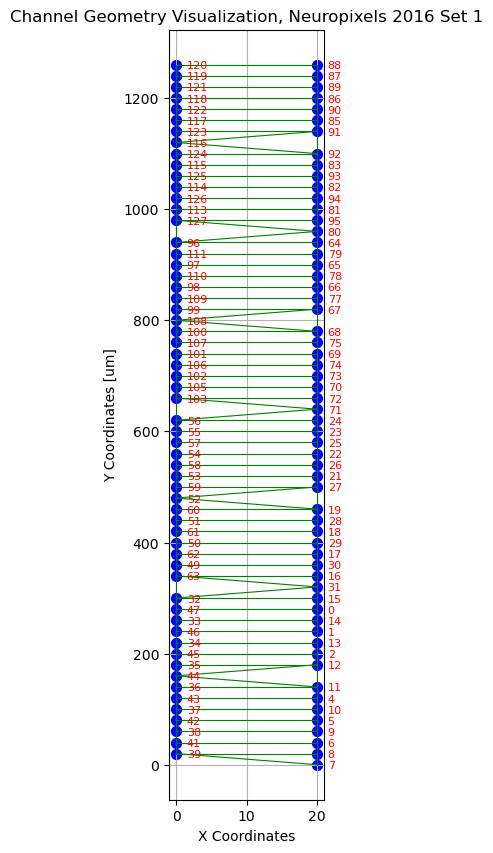

In [382]:
import matplotlib.pyplot as plt

# x, y 좌표 분리
x_coords = [coord[0] for coord in geometry.values()]
y_coords = [coord[1] for coord in geometry.values()]

# 플로팅
plt.figure(figsize=(2, 10))  # 그래프 크기 설정
plt.scatter(x_coords, y_coords, color='blue', label='Channels', s=50)

# 라벨 추가
for channel, (x, y) in geometry.items():
    plt.text(x + 1.5, y - 7, str(channel), fontsize=8, ha='left', color='red')

# 연결 정보 반영
for connection in graph:
    ch1, ch2 = connection
    x1, y1 = geometry[str(ch1)]
    x2, y2 = geometry[str(ch2)]
    plt.plot([x1, x2], [y1, y2], color='green', linewidth=0.8)  # 선 그리기

plt.title(f'Channel Geometry Visualization, Neuropixels 2016 Set {index + 1}')
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates [um]')
plt.grid(True)
plt.show()


In [386]:
gt_path = [
    f"/data2/spike_sorting/neuropixels_choi/set1/20141202_all_es_gtTimes.mat",
    f"/data2/spike_sorting/neuropixels_choi/set2/20150924_1_e_gtTimes.mat",
    f"/data2/spike_sorting/neuropixels_choi/set3/20150601_all_s_gtTimes.mat",
    f"/data2/spike_sorting/neuropixels_choi/set4/20150924_1_GT_gtTimes.mat",
]

index = 2

mat1 = io.loadmat(gt_path[index])
print('유닛개수',len(mat1['gtChans'][0]))

# 다음 채널은 geometry에 없다.
no = []
for i in range(129):
    if str(i) not in list(geometry.keys()):
        no.append(i)
print(F'geometry에 없는 채널 {len(no)}개: (0-start index) {no}')

유닛개수 8
geometry에 없는 채널 9개: (0-start index) [3, 20, 40, 48, 76, 84, 104, 112, 128]


In [384]:
gt_position = np.zeros((129, len(mat1['gtChans'][0])))
for i in range(len(mat1['gtChans'][0])):
    for j in mat1['gtChans'][0][i]:
        gt_position[j[0]-1][i] = 1

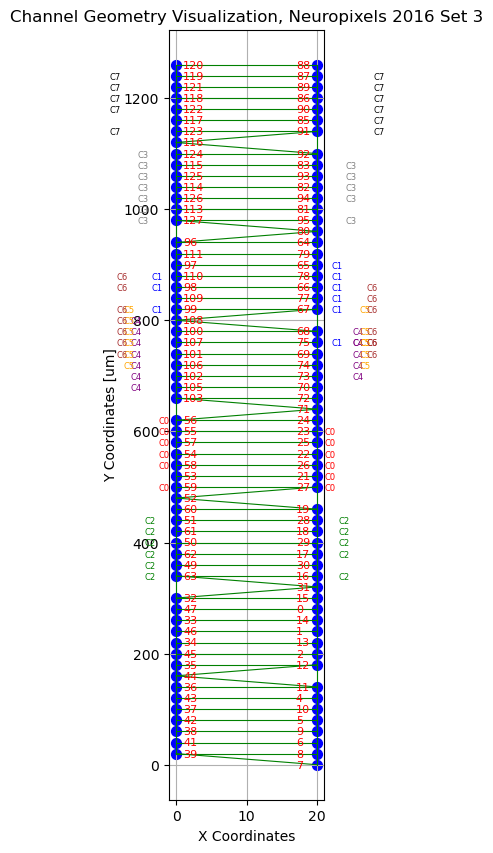

In [385]:
import matplotlib.pyplot as plt

colormap = ['red', 'blue', 'green', 'gray',  'purple', 'orange',  'brown', 'black']
# x, y 좌표 분리
x_coords = [coord[0] for coord in geometry.values()]
y_coords = [coord[1] for coord in geometry.values()]

# 플로팅
plt.figure(figsize=(2, 10))  # 그래프 크기 설정
plt.scatter(x_coords, y_coords, color='blue', label='Channels', s=50)

# 라벨 추가
for channel, (x, y) in geometry.items():
    x_offset = - 3 if x > 10 else + 1
    plt.text(x + x_offset, y - 6, str(channel), fontsize=8, color='red')

# 연결 정보 반영
for connection in graph:
    ch1, ch2 = connection
    x1, y1 = geometry[str(ch1)]
    x2, y2 = geometry[str(ch2)]
    plt.plot([x1, x2], [y1, y2], color='green', linewidth=0.8)  # 선 그리기

    # 넘파이 어레이의 1인 값 처리
for row_idx, row in enumerate(gt_position):
    for col_idx, value in enumerate(row):
        if value == 1:  # 값이 1인 경우
            channel = row_idx    # 채널 번호 (1부터 시작한다고 가정)
            if str(row_idx) in geometry.keys():
                x, y = geometry[str(channel)]  # 해당 채널의 좌표

            x_offxet = - (2.5)- 1*col_idx if x < 10 else + (1) + 1*col_idx 
            plt.text(x + x_offxet, y-6,  # 열값에 따라 위치 조정
                     f'C{col_idx}', fontsize=6, color=colormap[col_idx])


plt.title(f'Channel Geometry Visualization, Neuropixels 2016 Set {index + 1}')
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates [um]')
plt.grid(True)
plt.show()
